In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [19]:
file = 'params_texel'

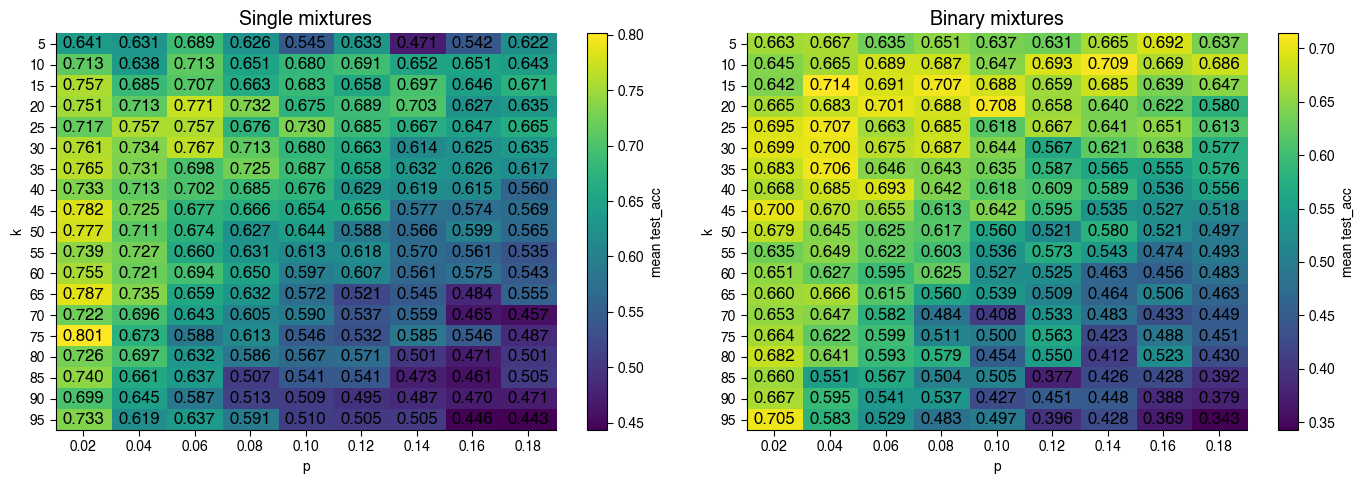

In [20]:
def load_grid(path):
    """Load a gridsearch pickle and return (grid, ku, pu)."""
    with open(path, "rb") as f:
        d = pickle.load(f)
    k  = np.asarray(d["params"]["k"])
    p  = np.asarray(d["params"]["p"])
    ta = np.asarray(d["results"]["test_acc"], dtype=float)

    idx = np.lexsort((p, k))
    ks, ps, tas = k[idx], p[idx], ta[idx]

    chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
    starts = np.r_[0, np.flatnonzero(chg) + 1]

    sums   = np.add.reduceat(tas, starts)
    counts = np.diff(np.r_[starts, tas.size])
    means  = sums / counts

    ku = np.unique(k)
    pu = np.unique(p)
    grid = np.full((ku.size, pu.size), np.nan)
    grid[np.searchsorted(ku, ks[starts]),
         np.searchsorted(pu, ps[starts])] = means
    return grid, ku, pu

# --- load both datasets ---
grid1, ku1, pu1 = load_grid(f"data/{file}.pkl")
grid2, ku2, pu2 = load_grid("data/params_texel_binary.pkl")

# --- plot side by side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, grid, ku, pu, title in [
    (ax1, grid1, ku1, pu1, "Single mixtures"),
    (ax2, grid2, ku2, pu2, "Binary mixtures"),
]:
    im = ax.imshow(grid, aspect="auto")
    ax.set_xticks(np.arange(pu.size))
    ax.set_xticklabels([f"{v:.2f}" for v in pu])
    ax.set_yticks(np.arange(ku.size))
    ax.set_yticklabels(ku)
    ax.set_xlabel("p")
    ax.set_ylabel("k")
    ax.set_title(title)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if np.isfinite(grid[i, j]):
                ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

    fig.colorbar(im, ax=ax, label="mean test_acc")

plt.tight_layout()
plt.show()